In [1]:
import import_ipynb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import decomposition
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [2]:
from Data_investigation import load_and_combine
from Data_investigation import filter_data
from Data_investigation import drop_columns
from Data_investigation import split_column_types
from Data_investigation import restructure_data
from Data_investigation import encode_and_concat
from Data_investigation import show_unique_values
from Data_investigation import count_unique

importing Jupyter notebook from Data_investigation.ipynb


In [3]:
Users=pd.read_csv('./ka_users.csv')

In [4]:
path1='./ka_devices.db'
path2='./ka_users.csv'
path3='./ka_actions.parquet'
columns_drop=['game_stats_tutorial_complete','index','device_os_s','device_mapped_s','geo_s','device_manufacturer_s','device_model_s','device_gpu_s','lang_s']

In [5]:
df=load_and_combine(path1,path2,path3)

In [6]:
df,s_nlls=filter_data(df)

In [7]:
#Use this to show where the Na's are. #It is also verified that the amount of Na's are small see 'Filter_Data()'
#s_nlls

In [8]:
df=drop_columns(df,columns_drop)

In [9]:
types,cat_types,cluster_types= split_column_types(df)

### Distinct Categorical values

In [10]:
### Use this to show how many distinct categorical values are present as well as the count. Consider grouping using regex and nltk 
#Show_Unique_Values(df_F,cat_types)
#Count_Unique(df_F,cat_types)

In [11]:
### Therefore remove more categorical data 
cat_types=[i for i in types['object'] if i not in columns_drop]

In [12]:
df=restructure_data(df,cluster_types)

In [13]:
X,y=df.drop(['total_spend'],axis=1),df.total_spend

In [14]:
X=encode_and_concat(X,cat_types)


In [15]:
### Hyperparameter tuning takes place here. A bit of trial and error 
dmatrix = xgb.DMatrix(data=X, label=y)
params = { 'max_depth': 100,
           'learning_rate': 0.3,
           'colsample_bytree': 0.3,
            'alpha': 50,
         'subsample': 0.6}
cv_results = xgb.cv(dtrain=dmatrix, 
                   params=params,
                   metrics='rmse', 
                   as_pandas=True,
                    num_boost_round=100,
                 early_stopping_rounds=20,
                   nfold=5)


In [16]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1.048762,0.001317,1.050063,0.005028
1,1.013383,0.001683,1.015827,0.005164
2,0.995624,0.001352,0.998848,0.005822
3,0.985551,0.001658,0.989722,0.005957
4,0.980085,0.002147,0.985027,0.005294


In [17]:
## since data is standardized, the mean response is 0. The rmse here is relatviely close to zero
print((cv_results["test-rmse-mean"]).tail(1))

26    0.976046
Name: test-rmse-mean, dtype: float64


In [18]:
## train model for Variable importance to determine which variables will build profile 
xg_reg = xgb.train(params=params, dtrain=dmatrix, num_boost_round=100)


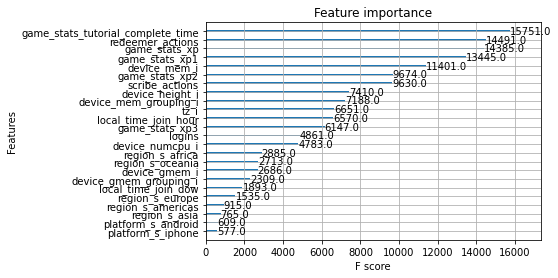

In [19]:
# Variable importance code 
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()